In [169]:
if '__IPYTHON__' in globals():
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay,ConfusionMatrixDisplay, PrecisionRecallDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate, train_test_split, cross_val_predict
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score

from sklearn import set_config
set_config(display="diagram")

In [170]:
target = "Loan_Status"
random_state= 42
test_size = 0.3

### 1. Import data

In [171]:
df = pd.read_csv("data/train.csv")
df["Loan_Status"] = df["Loan_Status"].map({"Y":1, "N":0})

X, y = (
    df.drop(target, axis=1),
    df.pop(target),
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

### 2. Prepare data

In [172]:
def fill_by_mode(X):
    X = X.apply(lambda x: x.fillna(x.mode()[0]), axis=1)
    return X

def log(X):
    return np.log(X)

def sum_features(X):
    X = X.apply(lambda x: x.sum(), axis=1) + offset
    return np.array(X).reshape(-1, 1)

### 3. Create the Pipeline

In [173]:
features = make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown="ignore", sparse=False),
        ),
        ["Gender", "Married", "Dependents", "Self_Employed", "Credit_History"],
    ),
    (
        make_pipeline(SimpleImputer(strategy="most_frequent"), StandardScaler()),
        ["Loan_Amount_Term"],
    ),
    (
        make_pipeline(SimpleImputer(strategy="median"), FunctionTransformer(log), StandardScaler()),
        ["LoanAmount"],
    ),
    (
        OneHotEncoder(handle_unknown="ignore", sparse=False),
        ["Education", "Property_Area"],
    ),
    (make_pipeline(SimpleImputer(strategy="median"), StandardScaler()), ["LoanAmount"]),
    ("passthrough", ["CoapplicantIncome"]),
)


### 4. Create the model

In [174]:
# The model
model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2', random_state=1, solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

### 5. Validation

In [175]:
# Transform X_train and X_val
X_train_features = features.fit_transform(X_train)
X_test_features = features.transform(X_test)

# Metrics to evaluate the model
scoring = ("accuracy","roc_auc", "f1")

# Cross validation
scores = cross_validate(
    model, X_train_features, y_train, cv=5, scoring=scoring, n_jobs=-1, return_train_score=True
)

# Mean value of the metrics
for k, v in scores.items():
    print(f"{k}: {v.mean():0.4f} (std: {v.var():0.4f})")

fit_time: 0.0017 (std: 0.0000)
score_time: 0.0021 (std: 0.0000)
test_accuracy: 0.8181 (std: 0.0002)
train_accuracy: 0.8217 (std: 0.0000)
test_roc_auc: 0.7604 (std: 0.0015)
train_roc_auc: 0.8154 (std: 0.0001)
test_f1: 0.8836 (std: 0.0001)
train_f1: 0.8858 (std: 0.0000)


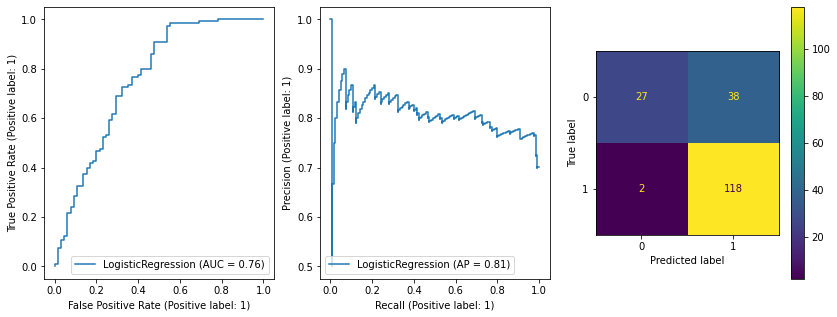

In [176]:
model.fit(X_train_features, y_train)
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
RocCurveDisplay.from_estimator(model, X_test_features, y_test, ax=ax[0])
PrecisionRecallDisplay.from_estimator(model, X_test_features, y_test, ax=ax[1])
ConfusionMatrixDisplay.from_estimator(model, X_test_features, y_test, ax=ax[2])
plt.show()

### 6. Make predictions and submit

In [177]:
test = pd.read_csv("data/test.csv")
test_features = features.transform(test)
y_test_pred = model.predict(test_features)

submission = pd.read_csv("data/sample_submission.csv")
submission['Loan_Status']= y_test_pred
submission['Loan_Status'] = submission['Loan_Status'].map({1:"Y", 0:"N"})
submission.to_csv(f"{model.__class__.__name__}.csv", index=False)